<a href="https://colab.research.google.com/github/nikhildr22/Speech-Emotion-Recognition/blob/master/fyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
''' Using Tensorflow 1.x '''

%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
''' listing directories '''
!ls

sample_data


In [0]:
''' Downloading the dataset from the website in zip compressed format '''
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2020-04-21 07:01:08--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  10.2MB/s    in 23s     

2020-04-21 07:01:33 (8.53 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [0]:
''' creating a folder - 'dataset' to keep the data '''
!mkdir dataset
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [0]:
''' unzipping the dataset into the destination folder 'dataset' '''
!unzip -q Audio_Speech_Actors_01-24.zip -d dataset

In [0]:
''' listing directories '''
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [0]:
''' Installing soundfile module via pip '''
!pip install soundfile

In [0]:
''' importing required modules '''
import librosa
from tqdm import tqdm
import soundfile
from scipy.io import wavfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt

In [0]:
''' creating a directory to keep clean files '''
!mkdir clean 

In [0]:
''' downsampling audio files to 16KHz and storing them in /clean directory ''' 
for f in tqdm(glob.glob("dataset/*/*")):
    signal, rate = librosa.load(path=f, sr=16000)
    wavfile.write(filename='clean/'+f[-24:],rate=rate,data=signal)

100%|██████████| 1440/1440 [06:00<00:00,  4.00it/s]


In [0]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to be observed in our project
observed_emotions=['sad','angry','happy','neutral']

In [0]:
''' Creating a pandas dataframe for structured handling of files in the dataset '''
import pandas as pd
#Dataframe will contain 2 columns 'file' and 'emotion'
dataframe = pd.DataFrame(columns=['file', 'emotion'])

In [0]:
''' filling the dataframe rows with values '''
for file in tqdm(glob.glob("clean/*")):
        file_name=os.path.basename(file[-24:])
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue

        dataframe = dataframe.append({'file': file, 'emotion': emotion}, ignore_index=True)

100%|██████████| 1440/1440 [00:02<00:00, 611.11it/s]


In [0]:
dataframe.describe()

,file,emotion
count,672,672
unique,672,4
top,clean/03-01-03-01-02-01-15.wav,happy
freq,1,192


In [0]:
''' Dividing the dataframe into test and train dataframes '''
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)

In [0]:
train.describe()

,file,emotion
count,537,537
unique,537,4
top,clean/03-01-03-01-02-01-15.wav,sad
freq,1,158


In [0]:
train.head()

,file,emotion
18,clean/03-01-04-02-02-02-12.wav,sad
353,clean/03-01-04-02-02-02-15.wav,sad
434,clean/03-01-03-01-01-01-23.wav,happy
278,clean/03-01-05-02-01-01-14.wav,angry
175,clean/03-01-04-02-02-02-06.wav,sad


In [0]:
test.describe()

,file,emotion
count,135,135
unique,135,4
top,clean/03-01-04-01-02-01-24.wav,happy
freq,1,43


In [0]:
''' preparing the training data for the model '''
x_train = []
y_train = []
for index,row in tqdm(train.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
            x_train.append(mfcc)
            y_train.append(emotion)


537it [00:08, 59.89it/s]


In [0]:
''' preparing the testing data for the model '''
x_test = []
y_test = []
for index,row in tqdm(test.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
            x_test.append(mfcc)
            y_test.append(emotion)

135it [00:02, 59.97it/s]


In [0]:
''' converting all the training and testing data into numpy arrays '''
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
'''Performing LabelEncoding for the categorical output data '''
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [0]:
label = LabelEncoder()
y_train = np_utils.to_categorical(label.fit_transform(y_train))
y_test = np_utils.to_categorical(label.fit_transform(y_test))

In [0]:
print('x_train shape = ',x_train.shape)
print('y_train shape = ',y_train.shape)
print('x_test shape = ',x_test.shape)
print('y_test shape = ',y_test.shape)

x_train shape =  (537, 40)
y_train shape =  (537, 4)
x_test shape =  (135, 40)
y_test shape =  (135, 4)


In [0]:
num_features = x_train.shape[1]
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 40


In [0]:
''' imports required for MLP classifier '''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
#Initializing the Multi Layer Perceptron Classifier
MLP_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                    hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500,verbose=1)

In [0]:
#Training the model
MLP_model.fit(x_train,y_train)

Iteration 1, loss = inf
Iteration 2, loss = 10.74413149
Iteration 3, loss = 12.05495072
Iteration 4, loss = 11.88240945
Iteration 5, loss = 8.30553094
Iteration 6, loss = 4.76873154
Iteration 7, loss = 6.23042321
Iteration 8, loss = 3.36679429
Iteration 9, loss = 4.86747477
Iteration 10, loss = 4.54501900
Iteration 11, loss = 2.82442990
Iteration 12, loss = 3.71166964
Iteration 13, loss = 2.95768497
Iteration 14, loss = 2.85817985
Iteration 15, loss = 2.47047615
Iteration 16, loss = 2.51837799
Iteration 17, loss = 2.29628060
Iteration 18, loss = 2.14204694
Iteration 19, loss = 2.01053048
Iteration 20, loss = 2.15284777
Iteration 21, loss = 2.07782186
Iteration 22, loss = 1.87162413
Iteration 23, loss = 1.94108915
Iteration 24, loss = 1.80118596
Iteration 25, loss = 1.99318870
Iteration 26, loss = 1.88332037
Iteration 27, loss = 1.75118658
Iteration 28, loss = 1.73326767
Iteration 29, loss = 1.76309196
Iteration 30, loss = 1.84059957
Iteration 31, loss = 1.64392284
Iteration 32, loss = 

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [0]:
#Predicting the results for the test set data
y_pred=MLP_model.predict(x_test)

In [0]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 45.19%


In [0]:
''' imports required for CNN model '''
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten 
from tensorflow.keras.layers import MaxPooling1D,Dropout

In [0]:
''' reshaping data before feeding into the model '''
input_shape = (num_features,1)
num_files = x_train.shape[0]
x_train = x_train.reshape(num_files,num_features,1)

In [0]:
''' CNN model '''
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=(3), input_shape=input_shape))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(128, kernel_size=(3)))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(32, kernel_size=(3)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(12, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))

In [0]:
''' compiling the model and printing summary '''
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 38, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 36, 64)            6208      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 34, 128)           24704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 9, 64)             24640     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 7, 32)             6176      
_________________________________________________________________
flatten_2 (Flatten)          (None, 224)              

In [0]:
''' CNN model training '''
final = cnn_model.fit(x_train, y_train, epochs=500,verbose=1, batch_size=256, validation_split=0.2)

Epoch 1/500
2/2 [==============================] - 0s 105ms/step - loss: 3.9218 - accuracy: 0.2587 - val_loss: 1.4197 - val_accuracy: 0.2315
Epoch 2/500
2/2 [==============================] - 0s 23ms/step - loss: 1.7710 - accuracy: 0.2424 - val_loss: 1.4701 - val_accuracy: 0.1389
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 1.5638 - accuracy: 0.1981 - val_loss: 1.3912 - val_accuracy: 0.2222
Epoch 4/500
2/2 [==============================] - 0s 21ms/step - loss: 1.4183 - accuracy: 0.3100 - val_loss: 1.3880 - val_accuracy: 0.2870
Epoch 5/500
2/2 [==============================] - 0s 21ms/step - loss: 1.4190 - accuracy: 0.2867 - val_loss: 1.3880 - val_accuracy: 0.2870
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 1.4041 - accuracy: 0.3170 - val_loss: 1.3865 - val_accuracy: 0.2870
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 1.4137 - accuracy: 0.3170 - val_loss: 1.3860 - val_accuracy: 0.2870
Epoch 8/500
2/2 [==

In [0]:
''' reshaping testing data before feeding into the model '''
num_testfiles = y_test.shape[0]
x_test = x_test.reshape(num_testfiles,num_features,1)

In [0]:
''' evaluating the testing accuracy for the trained model '''
test_loss,test_accuracy = cnn_model.evaluate(x_test, y_test)
print('Testing accuracy is :',test_accuracy*100,'%')

5/5 [==============================] - 0s 3ms/step - loss: 1.5706 - accuracy: 0.6741
Testing accuracy is : 67.40740537643433 %


In [0]:
''' imports required for playing sound files '''
import IPython.display as ipd

In [0]:
''' taking a random file from the testing data '''
random_data = test.sample()
file = random_data.iloc[0]['file']
original_emotion = random_data.iloc[0]['emotion']
ipd.Audio(filename=file,) # load a local WAV file

In [0]:
''' extracting features from the random file and feeding it to the model for prediction '''
with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            feature = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
print('Original emotion is : ' + original_emotion)
print('identified emotion is : ' + label.inverse_transform(result)[0])

Original emotion is : angry
identified emotion is : angry


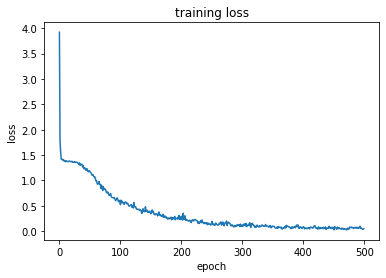

In [0]:
plt.plot(final.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('training loss')
plt.show()

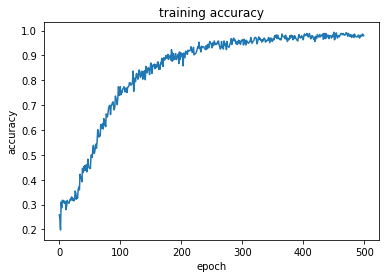

In [0]:
plt.plot(final.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('training accuracy')
plt.show()

In [0]:
print('predicted values for the test data: ',label.inverse_transform(cnn_model.predict_classes(x_test.reshape(len(x_test),num_features,1))))

predicted values for the test data:  ['sad' 'neutral' 'angry' 'sad' 'neutral' 'angry' 'happy' 'neutral' 'sad'
 'angry' 'angry' 'angry' 'angry' 'happy' 'sad' 'angry' 'happy' 'sad'
 'happy' 'happy' 'happy' 'happy' 'happy' 'angry' 'angry' 'sad' 'angry'
 'angry' 'angry' 'sad' 'angry' 'neutral' 'happy' 'happy' 'angry' 'happy'
 'neutral' 'angry' 'sad' 'happy' 'neutral' 'happy' 'angry' 'happy' 'happy'
 'neutral' 'happy' 'happy' 'happy' 'angry' 'sad' 'sad' 'sad' 'angry'
 'neutral' 'neutral' 'angry' 'sad' 'neutral' 'sad' 'happy' 'happy' 'angry'
 'happy' 'happy' 'neutral' 'sad' 'sad' 'sad' 'neutral' 'sad' 'neutral'
 'sad' 'angry' 'angry' 'sad' 'angry' 'angry' 'happy' 'neutral' 'neutral'
 'angry' 'sad' 'angry' 'happy' 'sad' 'neutral' 'sad' 'sad' 'sad' 'neutral'
 'sad' 'happy' 'happy' 'sad' 'neutral' 'neutral' 'sad' 'neutral' 'angry'
 'neutral' 'happy' 'sad' 'happy' 'sad' 'angry' 'neutral' 'happy' 'angry'
 'sad' 'angry' 'angry' 'happy' 'angry' 'happy' 'happy' 'neutral' 'angry'
 'happy' 'sad' 'neut